Visualisieren:
../../libMultiRobotPlanning-master/example/visualize.py test.yaml output.yaml


Basic Info:
[North, East, South, West]
DO_NOTHING= 0 MOVE_FORWARD= 2 MOVE_LEFT= 1 MOVE_RIGHT= 3 STOP_MOVING= 4

In [1]:
import sys
import time
from typing import Optional, List, Dict
import PIL
import yaml
import subprocess

import numpy as np

from flatland.core.env import Environment
from flatland.core.env_observation_builder import ObservationBuilder
from flatland.core.grid.grid_utils import coordinate_to_position
from flatland.envs.predictions import ShortestPathPredictorForRailEnv
from flatland.envs.rail_env import RailEnv
from flatland.envs.rail_generators import sparse_rail_generator
from flatland.envs.rail_generators import complex_rail_generator
from flatland.envs.schedule_generators import complex_schedule_generator
from flatland.envs.schedule_generators import sparse_schedule_generator
from flatland.utils.rendertools import RenderTool
from flatland.core.grid.grid4_utils import get_new_position


np.random.seed(100)

direction_to_str = {-1 : "pass...", 0: "North", 1: "East", 2: "South", 3: "West"}
action_to_str = {-1 : "pass...", 0 : "Do nothing", 1: "Left", 2 : "Forward", 3 : "Right", 4 : "Stop moving"}

In [9]:
# 3, 2, 2, 20, 20, agents 5

render = True
print_more_info = False

try:

    """
    rail_generator=sparse_rail_generator(
        max_num_cities = 3,
        grid_mode= False,
        max_rails_between_cities = 2,
        max_rails_in_city = 2, 
        seed=0
    )
    
    env = RailEnv(
        width=20, height=20,
        rail_generator=rail_generator,
        schedule_generator=sparse_schedule_generator(),
        number_of_agents=6
    )
    
    obs, info = env.reset()
    
    
    # Just do one dummy step so the Trains get a Position. My assumtion is, that it is always the same
    env.step({i : 2 for i in range(env.get_num_agents())})
    env.step({i : 2 for i in range(env.get_num_agents())})
    env.step({i : 2 for i in range(env.get_num_agents())})
    env.step({i : 2 for i in range(env.get_num_agents())})
    """

    print("Start searching...")
    
    res = get_scheudueles(env)
    print("Searching end!")

    # For rendering the Environment and the steps done by the agents
    if render: 
        env_renderer = RenderTool(env, screen_width=2000, screen_height=2000)
        env_renderer.render_env(show=True, frames=False, show_observations=False, show_predictions=False)
    
    # Empty action dictionary which has the predicted actions in it for each step
    action_dict = dict()
    
    # For Loop with all the steps predicted by the agent
    for step in range(1000):
        
        for handle in range(env.get_num_agents()):
        
            actions = res[handle]
            
            if not actions.is_empty() and info['action_required'][handle]:
                action_dict[handle] = actions.pop(0)

            else:
                action_dict[handle] = 0
        
        # Do the actual step in the Enviroment based on the action_dict computed previously 
        obs, all_rewards, done, info = env.step(action_dict)
        
        # Print the current status of the agents in each iteration
        print(f"[{step+1:3}] In goal: {[handle for handle, status in done.items() if status]}")
        
        if print_more_info:
            print("Iteration:", step)
            for handle, action in action_dict.items():
                print(f"<{handle}> Action: |{action}|, Position: {env.agents[handle].position}, Target: {env.agents[handle].target}, Direction: {direction_to_str[env.agents[handle].direction]}")

        if render: 
            env_renderer.render_env(show=True, frames=False, show_observations=False, show_predictions=False)
            time.sleep(.5)

        if done["__all__"]:
            print(f"\nAll Agents are in their targets! After {step+1} iterations.")
            break
            
finally:
    if render : env_renderer.close_window()


Start searching...
Searching end!
open_window - pyglet
[  1] In goal: []
[  2] In goal: []
[  3] In goal: []
[  4] In goal: []
[  5] In goal: []
[  6] In goal: []
[  7] In goal: []
[  8] In goal: []
[  9] In goal: []
[ 10] In goal: []
[ 11] In goal: []
[ 12] In goal: []
[ 13] In goal: []
[ 14] In goal: []
[ 15] In goal: []
[ 16] In goal: []
[ 17] In goal: []
[ 18] In goal: []
[ 19] In goal: []
[ 20] In goal: []
[ 21] In goal: []
[ 22] In goal: [6]
[ 23] In goal: [6]
[ 24] In goal: [4, 6]
[ 25] In goal: [3, 4, 6, 7]
[ 26] In goal: [2, 3, 4, 6, 7]
[ 27] In goal: [2, 3, 4, 6, 7, 8]
[ 28] In goal: [2, 3, 4, 6, 7, 8]
[ 29] In goal: [2, 3, 4, 6, 7, 8]
[ 30] In goal: [2, 3, 4, 6, 7, 8]
[ 31] In goal: [2, 3, 4, 6, 7, 8]
[ 32] In goal: [2, 3, 4, 6, 7, 8]
[ 33] In goal: [1, 2, 3, 4, 6, 7, 8]
[ 34] In goal: [1, 2, 3, 4, 6, 7, 8]
[ 35] In goal: [1, 2, 3, 4, 6, 7, 8]
[ 36] In goal: [0, 1, 2, 3, 4, 5, 6, 7, 8, '__all__']

All Agents are in their targets! After 36 iterations.


In [2]:
class ActionList:
    def __init__(self, actions):
        self.actions = actions
        
    def pop(self, n=0):
        # If the list is emmpty and there is no more to do, just return the wait action
        if len(self.actions) == 0:
            return 4
        
        return self.actions.pop(n)
    
    def is_empty(self):
        return len(self.actions) == 0
    
    def __repr__(self):
        return str(self.actions)
    

def get_scheudueles(env, outfilename="out.yaml"):
    
    # Create the file with all the actions by each agent
    grid_actions = get_grid_actions(env)
    
    # Get the grid to compute the heuristics later on
    grid = get_grid(env)
    
    # Run the C++ file with the created 
    # subprocess.run(["./../../libMultiRobotPlanning-master/build/cbs", "-i", grid_actions, "-g", grid, "-o", outfilename], check=True)

    # ../../libMultiRobotPlanning-master/build/output.yaml
    with open("../../libMultiRobotPlanning-master/build/output.yaml") as output_file:
          yaml_out = yaml.load(output_file, Loader=yaml.FullLoader)


    action_dict = dict()
    for handle, agent in enumerate(yaml_out["schedule"]):
        action_dict[handle] = ActionList(yaml_out["schedule"][str(agent)])
        
        
    return action_dict
        


# action_dict = get_scheudueles(env)


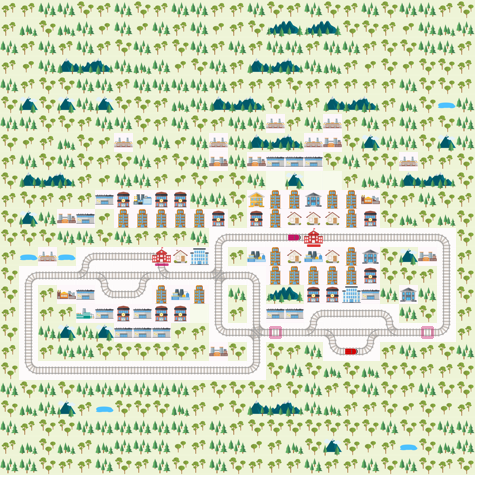

In [41]:
def render_env(env):
    env_renderer = RenderTool(env, gl="PILSVG")
    
    for i in range(env.get_num_agents()):
        
        if i == 1:
            env.dev_obs_dict[i] = [(17, 14) , (17, 22)]
        
        elif i == -1:
            env.dev_obs_dict[i] = [(10, 41), (10, 42), (11, 42), (11, 43), (11, 44), (11, 45), (11, 46), (12, 46), (13, 46), (14, 46), (15, 46), (16, 46), (17, 46), (18, 46), (19, 46), (20, 46), (21, 46), (22, 46), (23, 46), (24, 46), (25, 46), (26, 46), (27, 46), (28, 46), (29, 46), (30, 46), (31, 46), (32, 46), (33, 46), (33, 46), (33, 46), (33, 45), (33, 44), (33, 43), (33, 42), (33, 41), (33, 40), (33, 39), (33, 38), (33, 37), (33, 36), (34, 36), (34, 35), (34, 34), (34, 33), (34, 32), (34, 31), (35, 31), (36, 31), (36, 31), (37, 31), (37, 30), (38, 30), (38, 29), (38, 28), (38, 27), (38, 26), (38, 25), (38, 24), (37, 24), (36, 24), (35, 24), (34, 24), (33, 24), (32, 24), (31, 24), (30, 24), (29, 24), (28, 24), (27, 24), (26, 24), (25, 24), (24, 24), (23, 24), (22, 24), (21, 24), (21, 25), (20, 25), (19, 25), (19, 26), (18, 26), (17, 26)]
        
        else:
            env.dev_obs_dict[i] = [(33, 45)]
    
    
    
    env_renderer.render_env(show=True, frames=False, show_observations=True, show_predictions=False)

    image = env_renderer.get_image()
    pil_image = PIL.Image.fromarray(image)
    display(pil_image)

render_env(env)

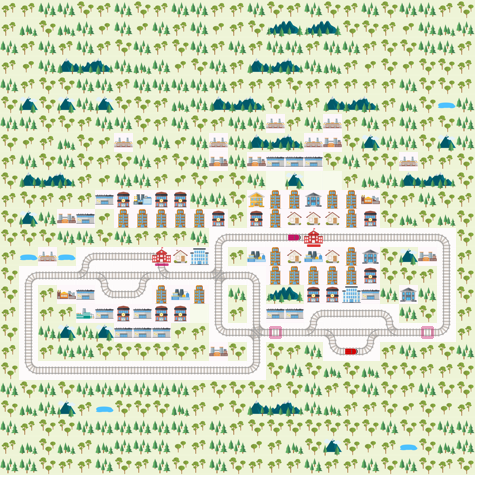

'grid.txt'

In [51]:
"""
rail_generator=sparse_rail_generator(
        max_num_cities = 3,
        grid_mode= False,
        max_rails_between_cities = 2,
        max_rails_in_city = 2, 
        seed=0
    )
    
env = RailEnv(
        width=20, height=20,
        rail_generator=rail_generator,
        schedule_generator=sparse_schedule_generator(),
        number_of_agents=3
    )
    
obs, info = env.reset()
env.step({i : 2 for i in range(env.get_num_agents())})
env.step({i : 2 for i in range(env.get_num_agents())})
env.step({i : 2 for i in range(env.get_num_agents())})
env.step({i : 2 for i in range(env.get_num_agents())})
"""

from flatland.envs.rail_generators import rail_from_file
env = RailEnv(
        width=0,
        height=0,
        rail_generator=rail_from_file("../scratch/test-envs/Test_6/Level_0.pkl"),
        number_of_agents=2
    )

_, info = env.reset()

for _ in range(1):
    env.step({i : 2 for i in range(env.get_num_agents())})

env.step({0 : 4, 1 : 2})


# env.step({0 : 4, 1 : 2, 2 : 2})

#for _ in range(10):
#    env.step({0 : 4, 1 : 2, 2 : 2})


render_env(env)

get_grid_actions(env)
get_grid(env)

In [52]:
for handle in range(env.get_num_agents()):
    print(handle, env.agents[handle].position)
    # print(handle, env.agents[handle].target)

0 (18, 18)
1 (12, 16)


In [5]:
class NextCell():
    
    def __init__(self, position, action, direction):
        self.position = position
        self.action = action
        self.direction = direction

    def __repr__(self):
        return f"{self.position} | {action_to_str[self.action]} | {direction_to_str[self.direction]}"


# Position, action, cost, direction
def calc_next_cell(position, direction):            
    
    possible_transitions = env.rail.get_transitions(*position, direction)

    # This should be never true when searching with the a star algorithm
    if all(d == 0 for d in possible_transitions):
        # print("This Direction is not permissable!")
        return -1
    
    # Initalize the next_cells with the action when there is done nothing/waiting (4), because this is alway possible
    next_cells = []

    # Loop trough all the possible dirrections the agent can reach from current direction
    for d in [(direction + i) % 4 for i in range(-1, 2)]:
        
        if possible_transitions[d]:
            
            # Die neue Position, wenn man die jeweilige direction 
            new_position = get_new_position(position, d)
            
            # Check the given directions and map it to the corresponding action
            if d == direction:
                next_cells.append(NextCell(new_position, 2, d))

            elif (d + 1) % 4 == direction:
                next_cells.append(NextCell(new_position, 1, d))
                
            elif (d - 1) % 4 == direction:
                next_cells.append(NextCell(new_position, 3, d))
    
    else:
    
        # Check if the transition is an dead End
        if possible_transitions[(direction + 2) % 4] == 1:
            direction = (direction + 2) % 4

            new_position = get_new_position(position, direction)

            next_cells.append(NextCell(new_position, 2, direction))
    
    return next_cells

In [6]:
def calc_coord(position):
    return [int(position[0]) , int(position[1])]


# This function is for creating the actions each agent can do in a certain cell
def get_grid_actions(env, filename="grid_actions.yaml"):
    env_map = env.distance_map.get()
    
    
    all_agents = []
    for handle, a in enumerate(env.agents):
        agent = {"goal" : calc_coord(a.target), "name" : "agent" + str(handle), "start" : calc_coord(a.position), "direction" : int(a.direction)}

        all_agents.append(agent)


    edges = []
    critcal = []
    for y in range(env.height):
        for x in range(env.width):
            if True in env.get_valid_directions_on_grid(y, x):

                position = (y, x)

                for direction in range(0, 4):
                    res = calc_next_cell(position, direction)

                    if res == -1:
                        continue

                    for new_pos in res:
                        edge = {"from" : calc_coord(position), "direction" : direction, "to" : calc_coord(new_pos.position), "action" : new_pos.action, "new_direction" : new_pos.direction}
                        edges.append(edge)

                
                # Check the critical positions
                for handle in range(env.get_num_agents()):
                    if np.count_nonzero(env_map[handle, y, x] == np.inf) < 2:
                        critcal.append(calc_coord(position))
                        break


    res_dict = {"agents" : all_agents, "map" : {"dimensions" : [env.height, env.width], "edges" : edges, "critical" : critcal}}

    f = open(filename, "w")
    yaml.dump(res_dict, f)
    f.close()
    
    return filename
    
    
# This function is for generating the grid of the map, which is then passed to the C++ file
def get_grid(env, filename="grid.txt"):
    
    res = ""
    np_shape = env.distance_map.get().shape
    env_map = env.distance_map.get()

    for handle in range(env.get_num_agents()):
        for y in range(np_shape[1]):
            for x in range(np_shape[2]):
                for value in list(env_map[handle, y, x]):

                    if value == np.inf:
                        res += str(-1) + " "
                    else:
                        res += str(int(value)) + " "

    f = open(filename, "w")
    f.write(str([int(i) for i in np_shape]) + "\n")
    f.write(res)
    f.close()
    
    return filename


# This function is for creating the map, which can then passed to the visualizer
def get_grid_python_visualization(env, filename="visualize_map.yaml"):
    agents = []

    for handle, a in enumerate(env.agents):
        agent = {"goal" : calc_coord(a.target), "name" : "agent" + str(handle), "start" : calc_coord(a.initial_position)}

        agents.append(agent)


    obstacles = []
    for y in range(env.width):
        for x in range(env.height):
            if not True in env.get_valid_directions_on_grid(x, y):
                obstacles.append(calc_coord((x, y)))

    res_dict = {"agents" : agents, "map" : {"dimensions" : [env.height, env.width], "obstacles" : obstacles}}


    f = open(filename, "w")
    yaml.dump(res_dict, f)
    f.close()
    
    return filename
    
get_grid_actions(env)
get_grid(env)

'grid.txt'